# Link Prediction - Heuristic Techniques

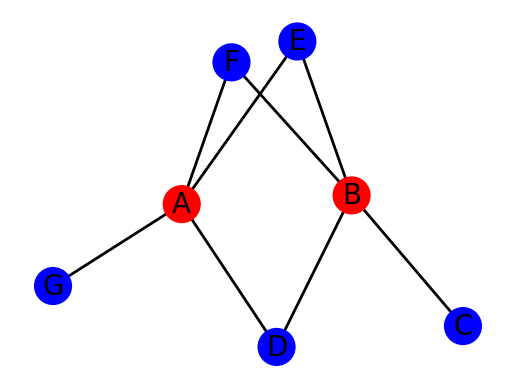

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

edges = [('B','C'), ('B', 'D'), ('A', 'D'), ('B', 'E'), ('A', 'E'),
         ('B', 'F'), ('A', 'F'), ('A', 'G')]

G = nx.Graph()
G.add_edges_from(edges)
# Plot the graph
pos = nx.spring_layout(G, seed=55)  # positions for all nodes

# Separate nodes A and B from the rest
node_color = ['red' if node in {'A', 'B'} else 'blue' for node in G.nodes()]

# Plot the graph
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_color)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=2)
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

plt.axis("off")
plt.show()

## Common Neighbors

In [ ]:
# Find common neighbors between nodes A and B
common_neighbors = list(nx.common_neighbors(G, 'A', 'B'))

# Print the number of common neighbors
print("Number of common neighbors between nodes A and B :", len(common_neighbors))

Number of common neighbors between nodes A and B : 3


## Jaccard`s Coefficient

In [ ]:
# Calculate the Jaccard coefficient between nodes A and B
jaccard_coefficient = nx.jaccard_coefficient(G, [('A', 'B')])

# Extract the Jaccard coefficient value from the result
for u, v, coefficient in jaccard_coefficient:
    print(f"Jaccard coefficient between nodes {u} and {v} : {coefficient}")

Jaccard coefficient between nodes A and B : 0.6


## Adamic-Adar Index

In [ ]:
# Calculate the Adamic-Adar index between nodes A and B
adamic_adar_index = nx.adamic_adar_index(G, [('A', 'B')])
# Extract the Adamic-Adar index value from the result
for u, v, coefficient in adamic_adar_index:
    print(f"Adamic-Adar index between nodes {u} and {v} : {coefficient}")

## Katz Index

In [ ]:
# Compute the Katz centrality for each node
katz_centrality = nx.katz_centrality(G , beta=0.8)

# Calculate the Katz index between nodes A and B
katz_index_A_B = katz_centrality['A'] * katz_centrality['B']

print(katz_centrality)
print(f"Katz index between nodes A and B: {katz_index_A_B}")

{'B': 0.4299639913515511, 'C': 0.32861535064845104, 'D': 0.3716117305820139, 'A': 0.4299639913515511, 'E': 0.3716117305820139, 'F': 0.3716117305820139, 'G': 0.32861535064845104}
0.4299639913515511
Katz index between nodes A and B: 0.18486903385895673


## Random walk with Restart(RWR)

In [ ]:
# Perform Random Walk with Restart (RWR) from node 'A'
target_node = 'A'
rwr_scores = nx.pagerank_alg.pagerank(G, personalization={'A': 1, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0})

# Sort nodes by RWR scores in descending order
sorted_nodes = sorted(rwr_scores, key=rwr_scores.get, reverse=True)
print("Random walk with restart score : ", rwr_scores)

# Predict links to the target node
predicted_links = [(target_node, node) for node in sorted_nodes if not G.has_edge(target_node, node) and node != target_node]

print("Predicted links to node ", predicted_links[0])

Random walk with restart score :  {'B': 0.1787363270364273, 'C': 0.03798182213105335, 'D': 0.11486524609277032, 'A': 0.36180268859249143, 'E': 0.11486524609277032, 'F': 0.11486524609277032, 'G': 0.07688342396171696}
Predicted links to node  ('A', 'B')


# Predicting Links with Graph Neural Networks

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Graph Autoencoder(GAE) and Variational Graph Autoencoder (VGAE)

In [43]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [48]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False), # 분할 비율, is_undireted : 방향성 지정, split_labels : edge label 지정, add_negative_train_samples : 학습을 위한 Negative Sample 추가 여부
])

dataset = Planetoid('.', name='Cora', transform=transform)

train_data, val_data, test_data = dataset[0]

print(train_data)
print(val_data)
print(test_data)

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[4488], pos_edge_label_index=[2, 4488])
Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[263], pos_edge_label_index=[2, 263], neg_edge_label=[263], neg_edge_label_index=[2, 263])
Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[527], pos_edge_label_index=[2, 527], neg_edge_label=[527], neg_edge_label_index=[2, 527])


In [19]:
from torch_geometric.nn import GCNConv, VGAE

class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.conv1 = GCNConv(dim_in, 2 * dim_out) # 평균, 표준편차 공유용 레이어
        self.conv_mu = GCNConv(2 * dim_out, dim_out) # 평균
        self.conv_logstd = GCNConv(2 * dim_out, dim_out) # 로그 표준 편차

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [78]:
model = VGAE(Encoder(dataset.num_features, 16)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index) + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index) # z Embedding 생성
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index) # 계산된 임베딩 z를 통하여, 기존에 있든 Edge와 존재하지 않는 Edge의 임베딩을 비교하여 평가, AUC AP 리턴.

for epoch in range(301):
    loss = train()
    if epoch % 50 == 0:
        val_auc, val_ap = test(val_data)
        print(f'Epoch {epoch:>3} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

test_auc, test_ap = test(test_data)
print(f'Test AUC: {test_auc:.4f} | Test AP {test_ap:.4f}')

Epoch   0 | Loss: 3.4846 | Val AUC: 0.6783 | Val AP: 0.7139
Epoch  50 | Loss: 1.3234 | Val AUC: 0.6702 | Val AP: 0.7081
Epoch 100 | Loss: 1.1881 | Val AUC: 0.7236 | Val AP: 0.7357
Epoch 150 | Loss: 1.0541 | Val AUC: 0.8161 | Val AP: 0.8157
Epoch 200 | Loss: 0.9917 | Val AUC: 0.8486 | Val AP: 0.8402
Epoch 250 | Loss: 0.9901 | Val AUC: 0.8592 | Val AP: 0.8481
Epoch 300 | Loss: 0.9422 | Val AUC: 0.8850 | Val AP: 0.8732
Test AUC: 0.8842 | Test AP 0.8895


In [79]:
z = model.encode(test_data.x, test_data.edge_index)
Ahat = torch.sigmoid(z @ z.T)
Ahat

tensor([[0.8227, 0.6670, 0.7368,  ..., 0.4279, 0.7163, 0.7966],
        [0.6670, 0.8688, 0.8652,  ..., 0.4912, 0.7815, 0.8140],
        [0.7368, 0.8652, 0.8772,  ..., 0.4599, 0.8160, 0.8489],
        ...,
        [0.4279, 0.4912, 0.4599,  ..., 0.5671, 0.4385, 0.4327],
        [0.7163, 0.7815, 0.8160,  ..., 0.4385, 0.7895, 0.8056],
        [0.7966, 0.8140, 0.8489,  ..., 0.4327, 0.8056, 0.8511]],
       grad_fn=<SigmoidBackward0>)

In [81]:
A = torch.zeros(test_data.num_nodes, test_data.num_nodes)
A[test_data.edge_index[0], test_data.edge_index[1]] = 1
A

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

## SEAL
특정 네트워크에 적합한 휴리스틱을 자동으로 학습하는 새로운 링크 예측 프레임워크<br>
SEAL은 각 대상 링크 주변의 로컬 하위 그래프를 데이터 표현으로 추출하고 그래프 신경망(GNN)을 기반으로 하위 그래프 패턴을 링크 존재에 매핑하는 기능을 학습합니다. SEAL은 또한 하위 그래프 패턴에 대한 추가 정보로 노드 임베딩 및 노드 속성으로부터 학습할 수 있습니다.

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.sparse.csgraph import shortest_path

import torch.nn.functional as F
from torch.nn import Conv1d, MaxPool1d, Linear, Dropout, BCEWithLogitsLoss

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, aggr
from torch_geometric.utils import k_hop_subgraph, to_scipy_sparse_matrix

In [ ]:
# Load Cora dataset
transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True)
dataset = Planetoid('.', name='Cora', transform=transform)
train_data, val_data, test_data = dataset[0]
train_data

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[4488], pos_edge_label_index=[2, 4488], neg_edge_label=[4488], neg_edge_label_index=[2, 4488])

In [ ]:
def seal_processing(dataset, edge_label_index, y):
    data_list = []

    for src, dst in edge_label_index.t().tolist():
        sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph([src, dst], 2, dataset.edge_index, relabel_nodes=True)
        src, dst = mapping.tolist()

        # Remove target link from the subgraph
        mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
        mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
        sub_edge_index = sub_edge_index[:, mask1 & mask2]

        # Double-radius node labeling (DRNL)
        src, dst = (dst, src) if src > dst else (src, dst)
        adj = to_scipy_sparse_matrix(sub_edge_index, num_nodes=sub_nodes.size(0)).tocsr()

        idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
        adj_wo_src = adj[idx, :][:, idx]

        idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
        adj_wo_dst = adj[idx, :][:, idx]

        # Calculate the distance between every node and the source target node
        d_src = shortest_path(adj_wo_dst, directed=False, unweighted=True, indices=src)
        d_src = np.insert(d_src, dst, 0, axis=0)
        d_src = torch.from_numpy(d_src)

        # Calculate the distance between every node and the destination target node
        d_dst = shortest_path(adj_wo_src, directed=False, unweighted=True, indices=dst-1)
        d_dst = np.insert(d_dst, src, 0, axis=0)
        d_dst = torch.from_numpy(d_dst)

        # Calculate the label z for each node
        dist = d_src + d_dst
        z = 1 + torch.min(d_src, d_dst) + dist // 2 * (dist // 2 + dist % 2 - 1)
        z[src], z[dst], z[torch.isnan(z)] = 1., 1., 0.
        z = z.to(torch.long)

        # Concatenate node features and one-hot encoded node labels (with a fixed number of classes)
        node_labels = F.one_hot(z, num_classes=200).to(torch.float)
        node_emb = dataset.x[sub_nodes]
        node_x = torch.cat([node_emb, node_labels], dim=1)

        # Create data object
        data = Data(x=node_x, z=z, edge_index=sub_edge_index, y=y)
        data_list.append(data)

    return data_list

In [ ]:
# Enclosing subgraphs extraction
train_pos_data_list = seal_processing(train_data, train_data.pos_edge_label_index, 1)
train_neg_data_list = seal_processing(train_data, train_data.neg_edge_label_index, 0)

val_pos_data_list = seal_processing(val_data, val_data.pos_edge_label_index, 1)
val_neg_data_list = seal_processing(val_data, val_data.neg_edge_label_index, 0)

test_pos_data_list = seal_processing(test_data, test_data.pos_edge_label_index, 1)
test_neg_data_list = seal_processing(test_data, test_data.neg_edge_label_index, 0)

In [ ]:
train_dataset = train_pos_data_list + train_neg_data_list
val_dataset = val_pos_data_list + val_neg_data_list
test_dataset = test_pos_data_list + test_neg_data_list

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class DGCNN(torch.nn.Module):
    def __init__(self, dim_in, k=30):
        super().__init__()

        # GCN layers
        self.gcn1 = GCNConv(dim_in, 32)
        self.gcn2 = GCNConv(32, 32)
        self.gcn3 = GCNConv(32, 32)
        self.gcn4 = GCNConv(32, 1)

        # Global sort pooling
        self.global_pool = aggr.SortAggregation(k=k)

        # Convolutional layers
        self.conv1 = Conv1d(1, 16, 97, 97)
        self.conv2 = Conv1d(16, 32, 5, 1)
        self.maxpool = MaxPool1d(2, 2)

        # Dense layers
        self.linear1 = Linear(352, 128)
        self.dropout = Dropout(0.5)
        self.linear2 = Linear(128, 1)

    def forward(self, x, edge_index, batch):
        # 1. Graph Convolutional Layers
        h1 = self.gcn1(x, edge_index).tanh()
        h2 = self.gcn2(h1, edge_index).tanh()
        h3 = self.gcn3(h2, edge_index).tanh()
        h4 = self.gcn4(h3, edge_index).tanh()
        h = torch.cat([h1, h2, h3, h4], dim=-1)

        # 2. Global sort pooling
        h = self.global_pool(h, batch)

        # 3. Traditional convolutional and dense layers
        h = h.view(h.size(0), 1, h.size(-1))
        h = self.conv1(h).relu()
        h = self.maxpool(h)
        h = self.conv2(h).relu()
        h = h.view(h.size(0), -1)
        h = self.linear1(h).relu()
        h = self.dropout(h)
        h = self.linear2(h).sigmoid()

        return h

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DGCNN(train_dataset[0].num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = BCEWithLogitsLoss()

def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.to(torch.float))
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    y_pred, y_true = [], []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        y_pred.append(out.view(-1).cpu())
        y_true.append(data.y.view(-1).cpu().to(torch.float))

    auc = roc_auc_score(torch.cat(y_true), torch.cat(y_pred))
    ap = average_precision_score(torch.cat(y_true), torch.cat(y_pred))

    return auc, ap

for epoch in range(31):
    loss = train()
    val_auc, val_ap = test(val_loader)
    print(f'Epoch {epoch:>2} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

test_auc, test_ap = test(test_loader)
print(f'Test AUC: {test_auc:.4f} | Test AP {test_ap:.4f}')

Epoch  0 | Loss: 0.6925 | Val AUC: 0.8215 | Val AP: 0.8357
Epoch  1 | Loss: 0.6203 | Val AUC: 0.8543 | Val AP: 0.8712
Epoch  2 | Loss: 0.5888 | Val AUC: 0.8783 | Val AP: 0.8877
Epoch  3 | Loss: 0.5815 | Val AUC: 0.8825 | Val AP: 0.8920
Epoch  4 | Loss: 0.5776 | Val AUC: 0.8917 | Val AP: 0.9025
Epoch  5 | Loss: 0.5747 | Val AUC: 0.8971 | Val AP: 0.9079
Epoch  6 | Loss: 0.5719 | Val AUC: 0.8932 | Val AP: 0.9027
Epoch  7 | Loss: 0.5688 | Val AUC: 0.9064 | Val AP: 0.9119
Epoch  8 | Loss: 0.5646 | Val AUC: 0.9007 | Val AP: 0.9112
Epoch  9 | Loss: 0.5599 | Val AUC: 0.9064 | Val AP: 0.9072
Epoch 10 | Loss: 0.5565 | Val AUC: 0.9037 | Val AP: 0.9043
Epoch 11 | Loss: 0.5538 | Val AUC: 0.9036 | Val AP: 0.9046
Epoch 12 | Loss: 0.5521 | Val AUC: 0.9038 | Val AP: 0.9051
Epoch 13 | Loss: 0.5509 | Val AUC: 0.8997 | Val AP: 0.8980
Epoch 14 | Loss: 0.5493 | Val AUC: 0.9018 | Val AP: 0.9027
Epoch 15 | Loss: 0.5483 | Val AUC: 0.8985 | Val AP: 0.8959
Epoch 16 | Loss: 0.5482 | Val AUC: 0.8990 | Val AP: 0.89